# Dislib tutorial

This tutorial will show the basics of using [dislib](https://dislib.bsc.es).


## Setup


First, we need to start an interactive PyCOMPSs session:

In [1]:
import pycompss.interactive as ipycompss
import os
if 'BINDER_SERVICE_HOST' in os.environ:
    ipycompss.start(graph=True,
                    project_xml='../xml/project.xml',
                    resources_xml='../xml/resources.xml')
else:
    ipycompss.start(graph=True, monitor=1000)

********************************************************
**************** PyCOMPSs Interactive ******************
********************************************************
*          .-~~-.--.           ______        ______    *
*         :         )         |____  \      /  __  \   *
*   .~ ~ -.\       /.- ~~ .      __) |      | |  | |   *
*   >       `.   .'       <     |__  |      | |  | |   *
*  (         .- -.         )   ____) |   _  | |__| |   *
*   `- -.-~  `- -'  ~-.- -'   |______/  |_| \______/   *
*     (        :        )           _ _ .-:            *
*      ~--.    :    .--~        .-~  .-~  }            *
*          ~-.-^-.-~ \_      .~  .-~   .~              *
*                   \ \ '     \ '_ _ -~                *
*                    \`.\`.    //                      *
*           . - ~ ~-.__\`.\`-.//                       *
*       .-~   . - ~  }~ ~ ~-.~-.                       *
*     .' .-~      .-~       :/~-.~-./:                 *
*    /_~_ _ . - ~              

Next, we import dislib and we are all set to start working!

In [2]:
import dislib as ds

## Distributed arrays

The main data structure in dislib is the distributed array (or ds-array). These arrays are a distributed representation of a 2-dimensional array that can be operated as a regular Python object. Usually, rows in the array represent samples, while columns represent features.

To create a random array we can run the following NumPy-like command:

In [3]:
x = ds.random_array(shape=(500, 500), block_size=(100, 100))
print(x.shape)
x

(500, 500)


ds-array(blocks=(...), top_left_shape=(100, 100), reg_shape=(100, 100), shape=(500, 500), sparse=False)

Now `x` is a 500x500 ds-array of random numbers stored in blocks of 100x100 elements. Note that `x` is not stored in memory. Instead, `random_array` generates the contents of the array in tasks that are usually executed remotely. This allows the creation of really big arrays.

The content of `x` is a list of `Futures` that represent the actual data (wherever it is stored).

To see this, we can access the `_blocks` field of `x`:

In [4]:
x._blocks[0][0]

`block_size` is useful to control the granularity of dislib algorithms.

To retrieve the actual contents of `x`, we use `collect`, which synchronizes the data and returns the equivalent NumPy array:

In [5]:
x.collect()

array([[0.3451024 , 0.25869311, 0.89644646, ..., 0.42138631, 0.65975316,
        0.87806334],
       [0.88885381, 0.08966281, 0.50941539, ..., 0.98043898, 0.54460031,
        0.65961968],
       [0.28812912, 0.80421186, 0.29949826, ..., 0.60478227, 0.49218688,
        0.20320584],
       ...,
       [0.56615823, 0.49948031, 0.80865568, ..., 0.15098277, 0.14796329,
        0.7788458 ],
       [0.10429495, 0.57530751, 0.20920522, ..., 0.25227913, 0.68076432,
        0.79716923],
       [0.99940303, 0.9218578 , 0.64824134, ..., 0.52287888, 0.82406785,
        0.24728267]])

Another way of creating ds-arrays is using array-like structures like NumPy arrays or lists:

In [6]:
x1 = ds.array([[1, 2, 3], [4, 5, 6]], block_size=(1, 3))
x1

ds-array(blocks=(...), top_left_shape=(1, 3), reg_shape=(1, 3), shape=(2, 3), sparse=False)

Distributed arrays can also store sparse data in CSR format:

In [7]:
from scipy.sparse import csr_matrix

sp = csr_matrix([[0, 0, 1], [1, 0, 1]])
x_sp = ds.array(sp, block_size=(1, 3))
x_sp

ds-array(blocks=(...), top_left_shape=(1, 3), reg_shape=(1, 3), shape=(2, 3), sparse=True)

In this case, `collect` returns a CSR matrix as well:

In [8]:
x_sp.collect()

<2x3 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

### Loading data

A typical way of creating ds-arrays is to load data from disk. Dislib currently supports reading data in CSV and SVMLight formats like this:

In [9]:
x, y = ds.load_svmlight_file("./files/libsvm/1", block_size=(20, 100), n_features=780, store_sparse=True)

print(x)

csv = ds.load_txt_file("./files/csv/1", block_size=(500, 122))

print(csv)

ds-array(blocks=(...), top_left_shape=(20, 100), reg_shape=(20, 100), shape=(61, 780), sparse=True)
ds-array(blocks=(...), top_left_shape=(500, 122), reg_shape=(500, 122), shape=(4235, 122), sparse=False)


### Slicing

Similar to NumPy, ds-arrays support the following types of slicing:

(Note that slicing a ds-array creates a new ds-array)

In [10]:
x = ds.random_array((50, 50), (10, 10))

Get a single row:

In [11]:
x[4]

ds-array(blocks=(...), top_left_shape=(1, 10), reg_shape=(10, 10), shape=(1, 50), sparse=False)

Get a single element:

In [12]:
x[2, 3]

ds-array(blocks=(...), top_left_shape=(1, 1), reg_shape=(1, 1), shape=(1, 1), sparse=False)

Get a set of rows or a set of columns:

In [13]:
# Consecutive rows
print(x[10:20])

# Consecutive columns
print(x[:, 10:20])

# Non consecutive rows
print(x[[3, 7, 22]])

# Non consecutive columns
print(x[:, [5, 9, 48]])

ds-array(blocks=(...), top_left_shape=(10, 10), reg_shape=(10, 10), shape=(10, 50), sparse=False)
ds-array(blocks=(...), top_left_shape=(10, 10), reg_shape=(10, 10), shape=(50, 10), sparse=False)
ds-array(blocks=(...), top_left_shape=(3, 10), reg_shape=(10, 10), shape=(3, 50), sparse=False)
ds-array(blocks=(...), top_left_shape=(10, 3), reg_shape=(10, 10), shape=(50, 3), sparse=False)


Get any set of elements:

In [14]:
x[0:5, 40:45]

ds-array(blocks=(...), top_left_shape=(5, 5), reg_shape=(10, 10), shape=(5, 5), sparse=False)

### Other functions

Apart from this, ds-arrays also provide other useful operations like `transpose` and `mean`:

In [15]:
x.mean(axis=0).collect()

array([0.44836739, 0.4458551 , 0.52146695, 0.44688053, 0.46488446,
       0.4805322 , 0.54499111, 0.51933234, 0.49223085, 0.49247272,
       0.49518099, 0.47144486, 0.48861912, 0.42819145, 0.47147381,
       0.52642021, 0.49316466, 0.52631078, 0.48916019, 0.46267375,
       0.4653973 , 0.50998791, 0.5089572 , 0.57128165, 0.49700653,
       0.48023375, 0.52125783, 0.5298717 , 0.48787633, 0.52148932,
       0.53245064, 0.51996209, 0.49826791, 0.49576398, 0.4848968 ,
       0.5717583 , 0.48768615, 0.50545307, 0.56430928, 0.54673216,
       0.50639053, 0.49519684, 0.45198639, 0.49809984, 0.43790849,
       0.58480675, 0.53228537, 0.50710879, 0.50326697, 0.53418791])

In [16]:
x.transpose().collect()

array([[0.33193626, 0.30770312, 0.8606486 , ..., 0.05589562, 0.01344953,
        0.23113577],
       [0.34427613, 0.31098603, 0.46684459, ..., 0.98039249, 0.0663997 ,
        0.80880373],
       [0.32007787, 0.80705679, 0.37000104, ..., 0.2401137 , 0.72337234,
        0.20998116],
       ...,
       [0.5090082 , 0.20704458, 0.20392792, ..., 0.87516504, 0.12375493,
        0.95245251],
       [0.0305576 , 0.36310337, 0.88709099, ..., 0.93023593, 0.22182147,
        0.59373211],
       [0.76967819, 0.56995315, 0.55426643, ..., 0.79626826, 0.38585529,
        0.14550786]])

## Machine learning with dislib

Dislib provides an estimator-based API very similar to [scikit-learn](https://scikit-learn.org/stable/). To run an algorithm, we first create an estimator. For example, a K-means estimator:

In [17]:
from dislib.cluster import KMeans

km = KMeans(n_clusters=3)

Now, we create a ds-array with some blob data, and fit the estimator:

In [18]:
from sklearn.datasets import make_blobs

# create ds-array
x, y = make_blobs(n_samples=1500)
x_ds = ds.array(x, block_size=(500, 2))

km.fit(x_ds)

KMeans(n_clusters=3, random_state=RandomState(MT19937) at 0x7F30A8041740)

Finally, we can make predictions on new (or the same) data:

In [19]:
y_pred = km.predict(x_ds)
y_pred

ds-array(blocks=(...), top_left_shape=(500, 1), reg_shape=(500, 1), shape=(1500, 1), sparse=False)

`y_pred` is a ds-array of predicted labels for `x_ds`

Let's plot the results

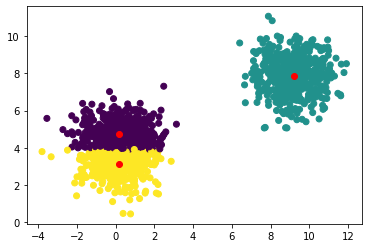

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt


centers = km.centers

# set the color of each sample to the predicted label
plt.scatter(x[:, 0], x[:, 1], c=y_pred.collect())

# plot the computed centers in red
plt.scatter(centers[:, 0], centers[:, 1], c='red')

Note that we need to call `y_pred.collect()` to retrieve the actual labels and plot them. The rest is the same as if we were using scikit-learn.

Now let's try a more complex example that uses some preprocessing tools.

First, we load a classification data set from scikit-learn into ds-arrays. 

Note that this step is only necessary for demonstration purposes. Ideally, your data should be already loaded in ds-arrays.

In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

x, y = load_breast_cancer(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y)

x_train = ds.array(x_train, block_size=(100, 10))
y_train = ds.array(y_train.reshape(-1, 1), block_size=(100, 1))

x_test = ds.array(x_test, block_size=(100, 10))
y_test = ds.array(y_test.reshape(-1, 1), block_size=(100, 1))

Next, we can see how support vector machines perform in classifying the data. We first fit the model (ignore any warnings in this step):

In [22]:
from dislib.classification import CascadeSVM

csvm = CascadeSVM()

csvm.fit(x_train, y_train)

/home/user/github/dislib/dislib/classification/csvm/base.py:395: RuntimeWarning: overflow encountered in exp
  k = np.exp(k)
/home/user/github/dislib/dislib/classification/csvm/base.py:363: RuntimeWarning: invalid value encountered in double_scalars
  delta = np.abs((w - self._last_w) / self._last_w)


CascadeSVM()

and now we can make predictions on new data using `csvm.predict()`, or we can get the model accuracy on the test set with:

In [23]:
score = csvm.score(x_test, y_test)

`score` represents the classifier accuracy, however, it is returned as a `Future`. We need to synchronize to get the actual value:

In [24]:
from pycompss.api.api import compss_wait_on

print(compss_wait_on(score))

0.6573426573426573


The accuracy should be around 0.6, which is not very good. We can scale the data before classification to improve accuracy. This can be achieved using dislib's `StandardScaler`.

The `StandardScaler` provides the same API as other estimators. In this case, however, instead of making predictions on new data, we transform it:

In [25]:
from dislib.preprocessing import StandardScaler

sc = StandardScaler()

# fit the scaler with train data and transform it
scaled_train = sc.fit_transform(x_train)

# transform test data
scaled_test = sc.transform(x_test)

Now `scaled_train` and `scaled_test` are the scaled samples. Let's see how SVM perfroms now.

In [26]:
csvm.fit(scaled_train, y_train)
score = csvm.score(scaled_test, y_test)
print(compss_wait_on(score))

0.986013986013986


The new accuracy should be around 0.9, which is a great improvement!

### Close the session

To finish the session, we need to stop PyCOMPSs:

In [27]:
ipycompss.stop()

********************************************************
*************** STOPPING PyCOMPSs ******************
********************************************************
Checking if any issue happened.
         have not been brought to the master.
********************************************************
